In [37]:
import warnings
warnings.filterwarnings("ignore")
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install numpy
!pip install xgboost
!pip install lightgbm
!pip install optuna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import LabelEncoder

import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

!pip install optuna
import optuna
import optuna.visualization as vis


In [46]:
df=pd.read_csv('cleaned_output.csv')
display (df.head())
print("Nombre total de lignes :", len(df))
df.info()

,genre,age,nationalite,niveauEtudes,sessionId,textId,associationType,personAType,valueOneA,valueTwoA,forceA,personBType,valueOneB,valueTwoB,forceB
0,homme,23,HRV,bac+4,420008aa-5136-48fb-9a6f-4347673fce87,67a243ea6d8e29a001947946,risk-reward,Robot,8,5,8,Personne âgée,2,5,3
1,homme,23,HRV,bac+4,420008aa-5136-48fb-9a6f-4347673fce87,67a243ea6d8e29a001947945,risk-reward,Femme petite taille,4,7,5,Robot,6,3,8
2,homme,23,HRV,bac+4,420008aa-5136-48fb-9a6f-4347673fce87,67a51efa18a0dfe14aac016b,risk-effort,Enfant,5,3,3,Femme petite taille,5,7,5
3,homme,23,HRV,bac+4,420008aa-5136-48fb-9a6f-4347673fce87,67a243ea6d8e29a001947947,effort-reward,Enfant,3,3,3,Femme petite taille,7,7,5
4,homme,23,HRV,bac+4,420008aa-5136-48fb-9a6f-4347673fce87,67a243ea6d8e29a001947949,effort-reward,Femme grande taille,5,5,7,Homme petite taille,5,5,6


Nombre total de lignes : 1398
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1398 entries, 0 to 1397
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   genre            1398 non-null   object
 1   age              1398 non-null   int64 
 2   nationalite      1398 non-null   object
 3   niveauEtudes     1398 non-null   object
 4   sessionId        1398 non-null   object
 5   textId           1398 non-null   object
 6   associationType  1398 non-null   object
 7   personAType      1398 non-null   object
 8   valueOneA        1398 non-null   int64 
 9   valueTwoA        1398 non-null   int64 
 10  forceA           1398 non-null   int64 
 11  personBType      1398 non-null   object
 12  valueOneB        1398 non-null   int64 
 13  valueTwoB        1398 non-null   int64 
 14  forceB           1398 non-null   int64 
dtypes: int64(7), object(8)
memory usage: 164.0+ KB


In [47]:
le = LabelEncoder()

df['sessionId'] = le.fit_transform(df['sessionId'])
df['textId'] = le.fit_transform(df['textId'])

#df.drop(columns=['_id_x','_id_y','__v_x','createdAt','__v_y'], inplace=True)
df.head()

,genre,age,nationalite,niveauEtudes,sessionId,textId,associationType,personAType,valueOneA,valueTwoA,forceA,personBType,valueOneB,valueTwoB,forceB
0,homme,23,HRV,bac+4,28,2,risk-reward,Robot,8,5,8,Personne âgée,2,5,3
1,homme,23,HRV,bac+4,28,1,risk-reward,Femme petite taille,4,7,5,Robot,6,3,8
2,homme,23,HRV,bac+4,28,8,risk-effort,Enfant,5,3,3,Femme petite taille,5,7,5
3,homme,23,HRV,bac+4,28,3,effort-reward,Enfant,3,3,3,Femme petite taille,7,7,5
4,homme,23,HRV,bac+4,28,5,effort-reward,Femme grande taille,5,5,7,Homme petite taille,5,5,6


In [48]:
reponses_hrv = df['nationalite'] == 'HRV'
#display(df[reponses_hrv])
print("------------------------------------------------")
display(len(df[reponses_hrv]))

------------------------------------------------


18

In [41]:
# nb de réponses par sessionId
sizeSession = df.groupby('sessionId').size()
# display(sizeSession)

# on renomme la colonne en n_reponses
session_counts = df.groupby('sessionId').size().reset_index(name='n_reponses')
display(session_counts)

# infos démographiques (en prenant la première ligne de chaque session)
demographics = df.groupby('sessionId').first().reset_index()[['sessionId', 'genre', 'age', 'nationalite', 'niveauEtudes']]
# display(demographics)

# stats agrégées sur les réponses (par exemple, moyennes)
response_stats = df.groupby('sessionId').agg({
    'valueOneA': 'mean',
    'valueTwoA': 'mean',
    'valueOneB': 'mean',
    'valueTwoB': 'mean'
    }).reset_index()

# display(response_stats)

# fusion des trois tables
summary_df = demographics.merge(session_counts, on='sessionId').merge(response_stats, on='sessionId')
display(summary_df)


# pour l'exporter
# summary_df.to_csv("resume_sessions.csv", index=False)

session_incompletes = summary_df[summary_df['n_reponses'] < 18]
session_completes = summary_df[summary_df['n_reponses'] >= 18]

print(f"Nombre de sessions incomplètes : {len(session_incompletes)}")
print(f"Nombre de sessions complètes : {len(session_completes)}")


,sessionId,n_reponses
0,0,8
1,1,34
2,2,14
3,3,18
4,4,2
...,...,...
88,88,5
89,89,18
90,90,2
91,91,18


,sessionId,genre,age,nationalite,niveauEtudes,n_reponses,valueOneA,valueTwoA,valueOneB,valueTwoB
0,0,femme,23,DZA,bac+4,8,5.000000,5.000000,5.000000,5.000000
1,1,homme,21,FRA,bac+3,34,4.764706,4.705882,5.235294,5.294118
2,2,homme,43,DZA,employe,14,4.928571,4.571429,5.071429,5.428571
3,3,homme,60,DZA,employe,18,5.000000,5.000000,5.000000,5.000000
4,4,femme,21,FRA,bac+3,2,6.500000,6.000000,3.500000,4.000000
...,...,...,...,...,...,...,...,...,...,...
88,88,femme,27,DZA,bac+5,5,5.000000,3.600000,5.000000,6.400000
89,89,homme,22,FRA,bac+4,18,6.888889,4.055556,3.111111,5.944444
90,90,homme,21,FRA,lycee,2,4.500000,4.000000,5.500000,6.000000
91,91,femme,47,DZA,employe,18,4.555556,4.611111,5.444444,5.388889


Nombre de sessions incomplètes : 29
Nombre de sessions complètes : 64


In [42]:
joueur_df = df[df['sessionId'] == 1]

display(joueur_df)

# juste voir les colonnes principales :
#print(joueur_df[['associationType', 'personAType', 'valueOneA', 'valueTwoA', 'forceA',
             #    'personBType', 'valueOneB', 'valueTwoB', 'forceB']])

,genre,age,nationalite,niveauEtudes,sessionId,textId,associationType,personAType,valueOneA,valueTwoA,forceA,personBType,valueOneB,valueTwoB,forceB
443,homme,21,FRA,bac+3,1,2,risk-reward,Homme petite taille,6,5,6,Femme petite taille,4,5,5
444,homme,21,FRA,bac+3,1,7,risk-effort,Personne âgée,3,7,5,Femme grande taille,7,3,7
445,homme,21,FRA,bac+3,1,3,effort-reward,Homme petite taille,3,3,6,Robot,7,7,10
446,homme,21,FRA,bac+3,1,8,risk-effort,Femme petite taille,7,3,5,Homme petite taille,3,7,6
447,homme,21,FRA,bac+3,1,2,risk-reward,Femme petite taille,5,5,5,Enfant,5,5,4
448,homme,21,FRA,bac+3,1,6,risk-effort,Homme petite taille,8,2,6,Robot,2,8,10
449,homme,21,FRA,bac+3,1,3,effort-reward,Femme petite taille,3,3,5,Homme petite taille,7,7,6
450,homme,21,FRA,bac+3,1,1,risk-reward,Robot,5,5,10,Homme grande taille,5,5,8
451,homme,21,FRA,bac+3,1,5,effort-reward,Femme grande taille,6,6,7,Femme petite taille,4,4,5
452,homme,21,FRA,bac+3,1,7,risk-effort,Femme grande taille,2,8,7,Homme grande taille,8,2,8


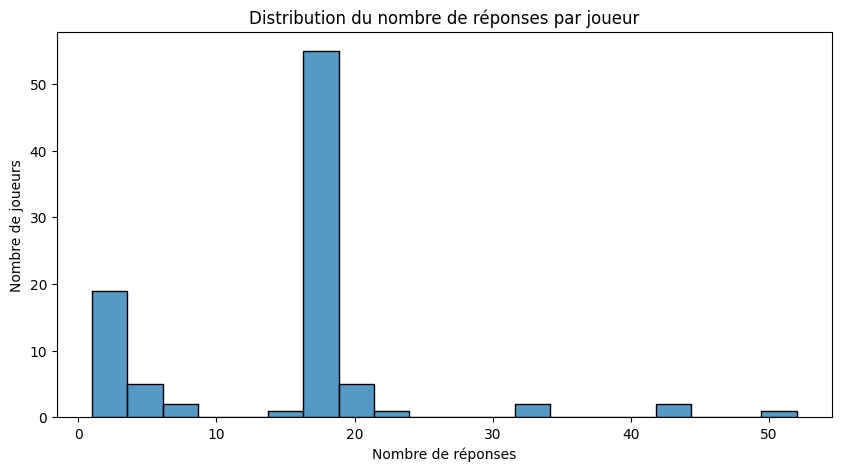

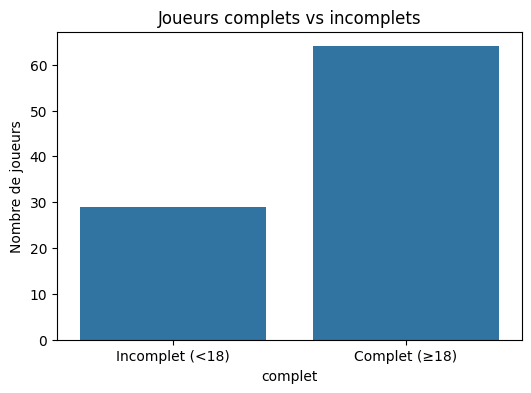

In [43]:
# Histogramme du nombre de réponses par joueur
plt.figure(figsize=(10, 5))
sns.histplot(summary_df['n_reponses'], bins=20, kde=False)
plt.title("Distribution du nombre de réponses par joueur")
plt.xlabel("Nombre de réponses")
plt.ylabel("Nombre de joueurs")
plt.show()

# nb de joueurs incomplets (<18) vs complets (≥18)
summary_df['complet'] = summary_df['n_reponses'] >= 18
complet_counts = summary_df['complet'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=complet_counts.index, y=complet_counts.values)
plt.xticks([0, 1], ['Incomplet (<18)', 'Complet (≥18)'])
plt.ylabel('Nombre de joueurs')
plt.title('Joueurs complets vs incomplets')
plt.show()


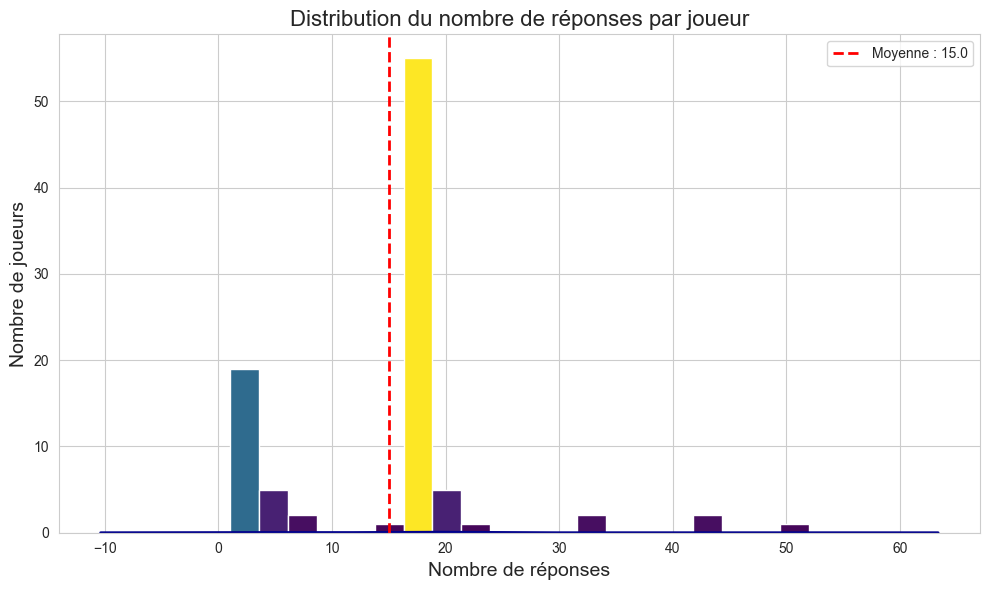

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Choix du style Seaborn
sns.set_style("whitegrid")

data = summary_df['n_reponses']
plt.figure(figsize=(10, 6))

# Trace de l'histogramme et récupération des patches
counts, bins, patches = plt.hist(data, bins=20, edgecolor='white', linewidth=1)

# Application d'un dégradé de couleurs
for count, patch in zip(counts, patches):
    patch.set_facecolor(plt.cm.viridis(count / counts.max()))

# Superposition du KDE
sns.kdeplot(data, color='darkblue', linewidth=2)

# Ligne de la moyenne
mean_val = data.mean()
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
            label=f'Moyenne : {mean_val:.1f}')

# Titres et légende
plt.title("Distribution du nombre de réponses par joueur", fontsize=16)
plt.xlabel("Nombre de réponses", fontsize=14)
plt.ylabel("Nombre de joueurs", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()



In [17]:
# Séparation complet/incomplet
plus_que_complets = summary_df[summary_df['n_reponses'] > 18]
complets = summary_df[summary_df['n_reponses'] == 18]
incomplets = summary_df[summary_df['n_reponses'] < 18]

n_complets = len(complets)
n_incomplets = len(incomplets)

display(f"Nombre de joueurs complets (=18 réponses) : {n_complets}")
display(f"Nombre de joueurs incomplets (<18 réponses) : {n_incomplets}")
display(f"Nombre de joueurs dépassant les 18 questions : {len(plus_que_complets)}")
display(f"Ratio de complets : {n_complets / (n_complets + n_incomplets)}")
display(f"Ratio de non-complets : {n_incomplets / (n_complets + n_incomplets)}")
display(f"Ratio de réponses dépassant 18 : {len(plus_que_complets) / (n_complets + n_incomplets)}")


'Nombre de joueurs complets (=18 réponses) : 53'

'Nombre de joueurs incomplets (<18 réponses) : 29'

'Nombre de joueurs dépassant les 18 questions : 11'

'Ratio de complets : 0.6463414634146342'

'Ratio de non-complets : 0.35365853658536583'

'Ratio de réponses dépassant 18 : 0.13414634146341464'

In [19]:
df_test = df.copy()

df_test['associationType'] = LabelEncoder().fit_transform(df_test['associationType'])
df_test['personAType'] = LabelEncoder().fit_transform(df_test['personAType'])
df_test['personBType'] = LabelEncoder().fit_transform(df_test['personBType'])
df_test['textId'] = LabelEncoder().fit_transform(df_test['textId'])

X = df_test[['textId', 'associationType', 'personAType', 'personBType', 'forceA', 'forceB']]
y = df_test[['valueOneA', 'valueOneB', 'valueTwoA', 'valueTwoB']]

In [20]:
# premier test initial

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def mae(y_true, y_pred): return mean_absolute_error(y_true, y_pred)
def rmse(y_true, y_pred): return np.sqrt(mean_squared_error(y_true, y_pred))
def r2(y_true, y_pred): return r2_score(y_true, y_pred)

models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    "Linear Regression": MultiOutputRegressor(LinearRegression())
}

# Définir KFold (pas stratified car régression)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scoring_metrics = {
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'R2': make_scorer(r2_score)
}

results = []

for name, model in models.items():
    row = {'Model': name}
    for metric_name, scorer in scoring_metrics.items():
        scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)
        row[metric_name] = f"{scores.mean():.3f} ± {scores.std():.3f}"
    results.append(row)

results_df = pd.DataFrame(results)

# tri par R2 décroissant
results_df_sorted = results_df.sort_values(by='R2', ascending=False)

print("Résultats de la validation croisée (5-fold) :")
display(results_df_sorted)

Résultats de la validation croisée (5-fold) :


,Model,MAE,RMSE,R2
1,Gradient Boosting,1.725 ± 0.055,2.294 ± 0.068,0.251 ± 0.037
0,Random Forest,1.699 ± 0.032,2.347 ± 0.043,0.213 ± 0.064
2,Linear Regression,1.837 ± 0.079,2.450 ± 0.080,0.144 ± 0.040


In [21]:
# A partir d'ici on teste pour la dimension effort 

In [23]:
complets = df.groupby('sessionId').filter(lambda x: len(x) >= 18)
incomplets = df.groupby('sessionId').filter(lambda x: len(x) < 18)

def prepare_data(sub_df):
    X_sub = sub_df[['textId',  'genre', 'age','niveauEtudes','associationType', 'personAType', 'personBType', 'forceA', 'forceB']]
    y_sub = sub_df[['valueOneA', 'valueOneB', 'valueTwoA', 'valueTwoB']]
    return X_sub, y_sub

X_complets, y_complets = prepare_data(complets)
X_incomplets, y_incomplets = prepare_data(incomplets)

In [24]:
df_bin = df.copy()

print(df_bin['associationType'].unique())

['risk-reward' 'risk-effort' 'effort-reward']


In [25]:
# deuxieme test (juste pour effort)

models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "XGBoost": MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42)),
    "LightGBM": MultiOutputRegressor(LGBMRegressor(random_state=42,force_row_wise=True))
}

# validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scoring_metrics = {
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'R2': make_scorer(r2_score)
}

def evaluate_models(X, y):
    results = []
    for name, model in models.items():
        row = {'Model': name}
        for metric_name, scorer in scoring_metrics.items():
            scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)
            row[metric_name] = f"{scores.mean():.3f} ± {scores.std():.3f}"
        results.append(row)
    return pd.DataFrame(results)

'''
# Exemple : tester sur l’effort uniquement
results_effort = evaluate_models(X_effort, y_effort)
print("\n📊 Résultats pour l'effort :")
print(results_effort)

results_complets = evaluate_models(X_complets, y_complets)
print("\n📊 Résultats pour joueurs complets :")
print(results_complets)

results_incomplets = evaluate_models(X_incomplets, y_incomplets)
print("\n📊 Résultats pour joueurs incomplets :")
print(results_incomplets)
'''

'\n# Exemple : tester sur l’effort uniquement\nresults_effort = evaluate_models(X_effort, y_effort)\nprint("\n📊 Résultats pour l\'effort :")\nprint(results_effort)\n\nresults_complets = evaluate_models(X_complets, y_complets)\nprint("\n📊 Résultats pour joueurs complets :")\nprint(results_complets)\n\nresults_incomplets = evaluate_models(X_incomplets, y_incomplets)\nprint("\n📊 Résultats pour joueurs incomplets :")\nprint(results_incomplets)\n'

In [26]:
def plot_results(results_df, title):
    # Convertir les colonnes MAE, RMSE, R2 en valeurs numériques (en enlevant le ±)
    for metric in ['MAE', 'RMSE', 'R2']:
        results_df[metric] = results_df[metric].str.extract(r'([0-9\.]+)').astype(float)

    # Restructurer pour seaborn (long format)
    melted = pd.melt(results_df, id_vars='Model', value_vars=['MAE', 'RMSE', 'R2'],
                     var_name='Metric', value_name='Score')

    plt.figure(figsize=(10, 6))
    sns.barplot(data=melted, x='Metric', y='Score', hue='Model')
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


'''
plot_results(results_effort, " Résultats pour l'effort")
plot_results(results_complets, " Résultats pour joueurs complets")
plot_results(results_incomplets, " Résultats pour joueurs incomplets")
'''



'\nplot_results(results_effort, " Résultats pour l\'effort")\nplot_results(results_complets, " Résultats pour joueurs complets")\nplot_results(results_incomplets, " Résultats pour joueurs incomplets")\n'

In [27]:
df_bin = df.copy()

complets = df_bin.groupby('sessionId').filter(lambda x: len(x) >= 18)
incomplets = df_bin.groupby('sessionId').filter(lambda x: len(x) < 18)

def prepare_data(sub_df):
    X_sub = sub_df[[ 'associationType',  'genre', 'age','niveauEtudes','personAType', 'personBType', 'forceA', 'forceB']]
    y_sub = sub_df[['valueOneA', 'valueOneB', 'valueTwoA', 'valueTwoB']]
    return X_sub, y_sub

X_complets, y_complets = prepare_data(complets)
X_incomplets, y_incomplets = prepare_data(incomplets)


label_encoders = {}
for col in [ 'genre','age','niveauEtudes', 'associationType', 'personAType', 'personBType']:
    le = LabelEncoder()
    df_bin[col] = le.fit_transform(df_bin[col])
    label_encoders[col] = le  # on garde l’encodeur pour plus tard

# récupération des codes pour chaque dimension
risk_codes = label_encoders['associationType'].transform(['risk-effort', 'risk-reward'])
effort_codes = label_encoders['associationType'].transform(['risk-effort', 'effort-reward'])
reward_codes = label_encoders['associationType'].transform(['risk-reward', 'effort-reward'])

# on filtre les datasets
risk_df = df_bin[df_bin['associationType'].isin(risk_codes)]
effort_df = df_bin[df_bin['associationType'].isin(effort_codes)]
reward_df = df_bin[df_bin['associationType'].isin(reward_codes)]

# def les différents X
X_risk = risk_df[['associationType', 'genre', 'age','niveauEtudes', 'personAType', 'personBType', 'forceA', 'forceB']]
X_effort = effort_df[['associationType', 'genre','age','niveauEtudes', 'personAType', 'personBType', 'forceA', 'forceB']]
X_reward = reward_df[['associationType', 'personAType', 'genre','age','niveauEtudes','personBType', 'forceA', 'forceB']]

# def y selon la colonne correspondant à la dimension

# RISK
risk_reward_code = label_encoders['associationType'].transform(['risk-reward'])[0]
risk_effort_code = label_encoders['associationType'].transform(['risk-effort'])[0]

risk_part1 = risk_df[risk_df['associationType'] == risk_effort_code][['valueOneA', 'valueOneB']]
risk_part2 = risk_df[risk_df['associationType'] == risk_reward_code][['valueOneA', 'valueOneB']]
y_risk = pd.concat([risk_part1, risk_part2]).sort_index()

risk_part1 = risk_part1.rename(columns={'valueOneA': 'riskA', 'valueOneB': 'riskB'})
risk_part2 = risk_part2.rename(columns={'valueOneA': 'riskA', 'valueOneB': 'riskB'})
y_risk = pd.concat([risk_part1, risk_part2]).sort_index()


# EFFORT
effort_effort_code = label_encoders['associationType'].transform(['effort-reward'])[0]

effort_part1 = effort_df[effort_df['associationType'] == risk_effort_code][['valueTwoA', 'valueTwoB']]
effort_part2 = effort_df[effort_df['associationType'] == effort_effort_code][['valueOneA', 'valueOneB']]
y_effort = pd.concat([effort_part1, effort_part2]).sort_index()

effort_part1 = effort_part1.rename(columns={'valueTwoA': 'effortA', 'valueTwoB': 'effortB'})
effort_part2 = effort_part2.rename(columns={'valueOneA': 'effortA', 'valueOneB': 'effortB'})
y_effort = pd.concat([effort_part1, effort_part2]).sort_index()


# REWARD
reward_part1 = reward_df[reward_df['associationType'] == risk_reward_code][['valueTwoA', 'valueTwoB']]
reward_part2 = reward_df[reward_df['associationType'] == effort_effort_code][['valueTwoA', 'valueTwoB']]
y_reward = pd.concat([reward_part1, reward_part2]).sort_index()

reward_part1 = reward_part1.rename(columns={'valueTwoA': 'rewardA', 'valueTwoB': 'rewardB'})
reward_part2 = reward_part2.rename(columns={'valueTwoA': 'rewardA', 'valueTwoB': 'rewardB'})
y_reward = pd.concat([reward_part1, reward_part2]).sort_index()


print("Infos des features X : ")
print("")

display(X_risk.columns)
display(X_risk.shape)

display(X_effort.columns)
display(X_effort.shape)

display(X_reward.columns)
display(X_reward.shape)

print("------------------------------------------------")


print("Infos des targets y : ")
print("")

display(y_risk.columns)
display(y_risk.shape)

display(y_effort.columns)
display(y_effort.shape)

display(y_reward.columns)
display(y_reward.shape)

print("------------------------------------------------")


print("Premieres valeurs des features X")

display(X_risk.head())
display(X_effort.head())
display(X_reward.head())

print("------------------------------------------------")


print("Premieres valeurs des targets y")

display(y_risk.head())
display(y_effort.head())
display(y_reward.head())


print("Risk part 1 et 2")
display(risk_part1)
display(risk_part2)

Infos des features X : 



Index(['associationType', 'genre', 'age', 'niveauEtudes', 'personAType',
       'personBType', 'forceA', 'forceB'],
      dtype='object')

(922, 8)

Index(['associationType', 'genre', 'age', 'niveauEtudes', 'personAType',
       'personBType', 'forceA', 'forceB'],
      dtype='object')

(937, 8)

Index(['associationType', 'personAType', 'genre', 'age', 'niveauEtudes',
       'personBType', 'forceA', 'forceB'],
      dtype='object')

(937, 8)

------------------------------------------------
Infos des targets y : 



Index(['riskA', 'riskB'], dtype='object')

(922, 2)

Index(['effortA', 'effortB'], dtype='object')

(937, 2)

Index(['rewardA', 'rewardB'], dtype='object')

(937, 2)

------------------------------------------------
Premieres valeurs des features X


,associationType,genre,age,niveauEtudes,personAType,personBType,forceA,forceB
0,2,1,8,3,6,5,8,3
1,2,1,8,3,2,6,5,8
2,1,1,8,3,0,2,3,5
5,2,1,8,3,4,5,6,3
6,2,1,8,3,3,4,9,6


,associationType,genre,age,niveauEtudes,personAType,personBType,forceA,forceB
2,1,1,8,3,0,2,3,5
3,0,1,8,3,0,2,3,5
4,0,1,8,3,1,4,7,6
7,0,1,8,3,5,1,3,7
8,1,1,8,3,4,0,6,3


,associationType,personAType,genre,age,niveauEtudes,personBType,forceA,forceB
0,2,6,1,8,3,5,8,3
1,2,2,1,8,3,6,5,8
3,0,0,1,8,3,2,3,5
4,0,1,1,8,3,4,7,6
5,2,4,1,8,3,5,6,3


------------------------------------------------
Premieres valeurs des targets y


,riskA,riskB
0,8,2
1,4,6
2,5,5
5,8,2
6,6,4


,effortA,effortB
2,3,7
3,3,7
4,5,5
7,3,7
8,8,2


,rewardA,rewardB
0,5,5
1,7,3
3,3,7
4,5,5
5,8,2


Risk part 1 et 2


,riskA,riskB
2,5,5
8,7,3
10,7,3
11,4,6
12,8,2
...,...,...
1384,10,0
1385,0,10
1386,0,10
1389,5,5


,riskA,riskB
0,8,2
1,4,6
5,8,2
6,6,4
9,3,7
...,...,...
1383,5,5
1390,0,10
1391,0,10
1392,5,5


In [30]:
# Évaluer
results_risk = evaluate_models(X_risk, y_risk)
results_effort = evaluate_models(X_effort, y_effort)
results_reward = evaluate_models(X_reward, y_reward)

# Afficher
print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Risk :")
print(results_risk)

print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Effort :")
print(results_effort)

print("-----------------------------------------------------------")

print("\n Résultats pour la dimension Reward :")
print(results_reward)

[LightGBM] [Info] Total Bins 68
[LightGBM] [Info] Number of data points in the train set: 737, number of used features: 8
[LightGBM] [Info] Start training from score 5.042062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


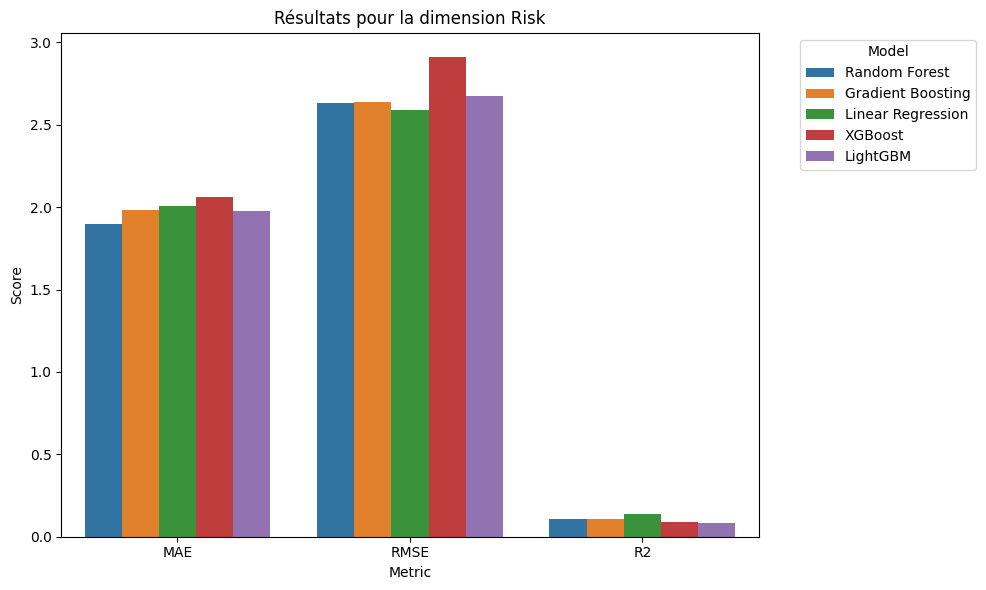

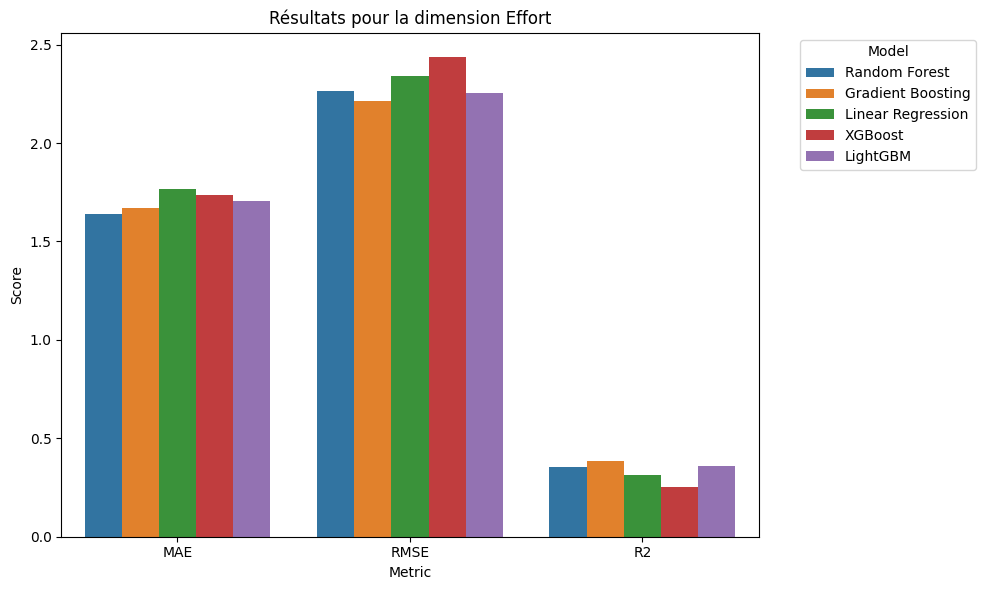

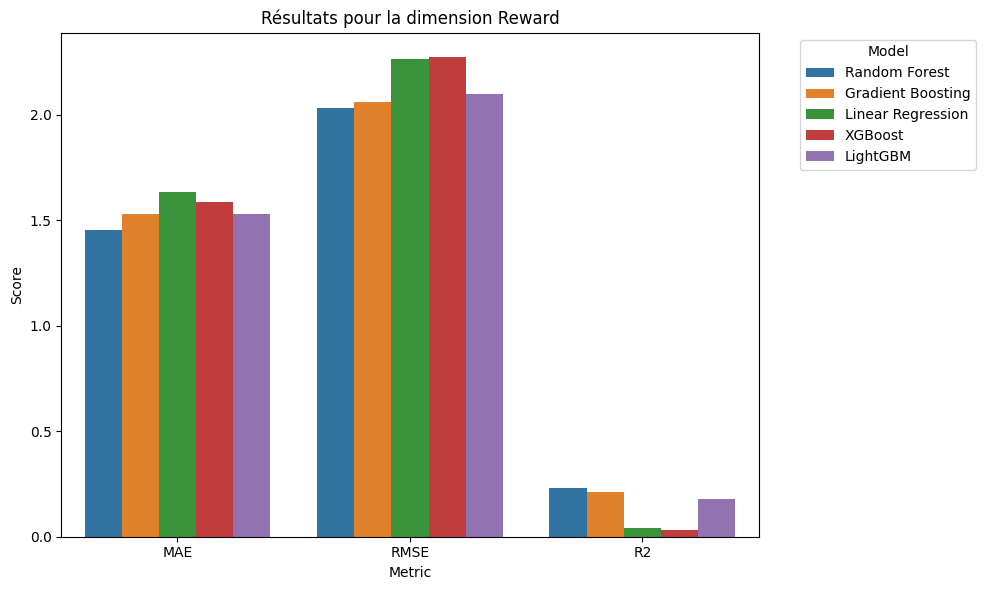

In [31]:
def plot_results(results_df, title):
    df_copy = results_df.copy()
    for metric in ['MAE', 'RMSE', 'R2']:
        df_copy[metric] = df_copy[metric].str.extract(r'([0-9\.]+)').astype(float)
    melted = pd.melt(df_copy, id_vars='Model', value_vars=['MAE', 'RMSE', 'R2'],
                     var_name='Metric', value_name='Score')

    plt.figure(figsize=(10, 6))
    sns.barplot(data=melted, x='Metric', y='Score', hue='Model')
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_results(results_risk, "Résultats pour la dimension Risk")
plot_results(results_effort, "Résultats pour la dimension Effort")
plot_results(results_reward, "Résultats pour la dimension Reward")


,Model,MAE,RMSE,R2,Dimension
0,Random Forest,1.899 ± 0.138,2.632 ± 0.200,0.108 ± 0.139,Risk
1,Gradient Boosting,1.985 ± 0.129,2.637 ± 0.149,0.107 ± 0.103,Risk
2,Linear Regression,2.009 ± 0.099,2.591 ± 0.140,0.139 ± 0.087,Risk
3,XGBoost,2.060 ± 0.165,2.912 ± 0.208,-0.090 ± 0.157,Risk
4,LightGBM,1.978 ± 0.094,2.676 ± 0.129,0.081 ± 0.095,Risk
0,Random Forest,1.637 ± 0.073,2.265 ± 0.096,0.355 ± 0.054,Effort
1,Gradient Boosting,1.669 ± 0.056,2.213 ± 0.099,0.384 ± 0.061,Effort
2,Linear Regression,1.764 ± 0.090,2.339 ± 0.103,0.314 ± 0.035,Effort
3,XGBoost,1.737 ± 0.088,2.438 ± 0.124,0.253 ± 0.072,Effort
4,LightGBM,1.707 ± 0.065,2.253 ± 0.108,0.361 ± 0.065,Effort


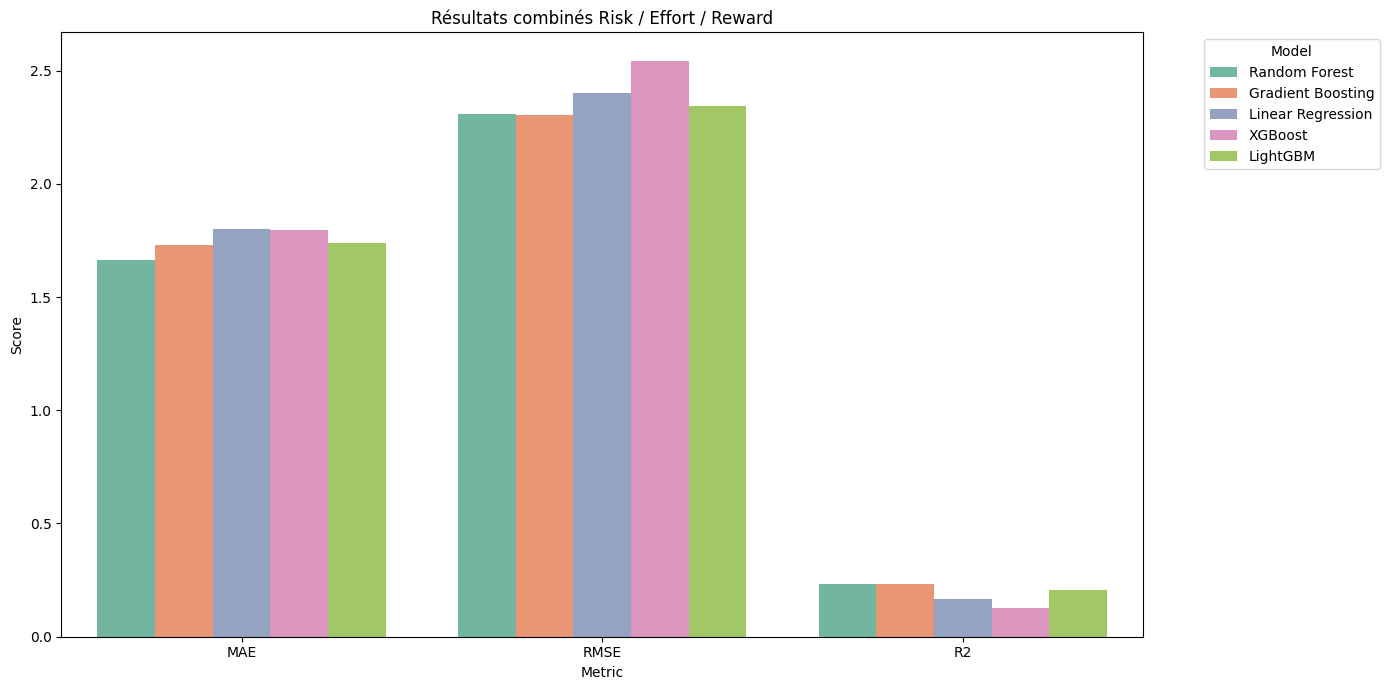

In [32]:
def combine_results(results_risk, results_effort, results_reward):
    risk = results_risk.copy()
    risk['Dimension'] = 'Risk'
    effort = results_effort.copy()
    effort['Dimension'] = 'Effort'
    reward = results_reward.copy()
    reward['Dimension'] = 'Reward'

    combined = pd.concat([risk, effort, reward], axis=0)
    return combined
def plot_combined_results(combined_df):
    df_copy = combined_df.copy()
    for metric in ['MAE', 'RMSE', 'R2']:
        df_copy[metric] = df_copy[metric].str.extract(r'([0-9\.]+)').astype(float)

    melted = pd.melt(df_copy, id_vars=['Model', 'Dimension'], value_vars=['MAE', 'RMSE', 'R2'],
                     var_name='Metric', value_name='Score')

    plt.figure(figsize=(14, 7))
    sns.barplot(data=melted, x='Metric', y='Score', hue='Model', ci=None, palette='Set2', dodge=True)
    plt.title("Résultats combinés Risk / Effort / Reward")
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

combined_results = combine_results(results_risk, results_effort, results_reward)
display(combined_results)

plot_combined_results(combined_results)

In [ ]:
#Prédiction simultanée des trois dimensions------Multi-output regressor-----

In [36]:

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1) Définir X (features) et y (les 3 cibles)
# Remplace 'age', 'sessionId_enc', 'textId_enc', ... par tes colonnes features
features = ['textId',  'genre', 'age','niveauEtudes','associationType', 'personAType', 'personBType', 'forceA', 'forceB']
X = df[features]

# 2) Tes 4 cibles, exactement comme dans ton Etape1.ipynb
target_cols = ['valueOneA', 'valueOneB', 'valueTwoA', 'valueTwoB']
y = df[target_cols]

# 2) Encoder toutes les colonnes non-numériques
X = pd.get_dummies(X, drop_first=True)  
# → crée autant de colonnes “sexe_femme” que nécessaire, etc.

# 3) Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) Entraînement
base_model = RandomForestRegressor(n_estimators=100, random_state=42)
model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

# 5) Prédiction et métriques
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
r2   = r2_score(y_test, y_pred, multioutput='raw_values')

print(f"RMSE [OneA, OneB, TwoA, TwoB] : {rmse}")
print(f"R²   [OneA, OneB, TwoA, TwoB] : {r2}")

RMSE [OneA, OneB, TwoA, TwoB] : [2.32446386 2.317613   2.29640276 2.30390196]
R²   [OneA, OneB, TwoA, TwoB] : [0.30552366 0.30961127 0.28046261 0.27575545]
